# Submission Guide

* **DO NOT** use other libraries.
* Please **DO NOT** modify the provided skeleton code; just fill in the TODO parts.
*   After completion of implementation, you should run all the cells
*   Submit your ipython notebook in 'ipynb' format
    * Do not remove your output results from every cells
    * Please check the file name extension
*   File name format: lab2_studentID_name.
ipynb
    * Ex) lab2_20233809_MinsungHwang.ipynb

* We do not accept late submissions

# Install scikit-network

In [1]:
%pip install scikit-network==0.29.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-network: filename=scikit_network-0.29.0-cp311-cp311-linux_x86_64.whl size=7176550 sha256=5fd68008af2c67bf81c1084972284f6d23a1e25faf8306b1fb89c9fad3d5c047
  Stored in directory: /root/.cache/pip/wheels/7b/06/b9/04961c77175148ca60b123f43b4ebc538b7d632bfdbede7c01
Successfully built scikit-network


# Load Data

Load 'karate_club' dataset from sknetwork.data

In [2]:
from sknetwork.data import karate_club

graph = karate_club(True)

In [4]:
import numpy as np
import scipy.sparse as sp

np.set_printoptions(precision=2, suppress=True)
np.random.seed(seed=717)

adj = graph.adjacency # 0/1 adjacency matrix in the form of csr_matrix

# Sample only 'num_edges' weight values in (0, 1]
num_edges = adj.nnz # number of nonzero values
adj_w = adj.copy().astype(float)
adj_w[adj > 0] = (1-np.random.rand(num_edges))

print("0/1 adjacency matrix: " + adj.__repr__())
print("Weighted adjacency matrix: " + adj_w.__repr__())

0/1 adjacency matrix: <Compressed Sparse Row sparse matrix of dtype 'bool'
	with 156 stored elements and shape (34, 34)>
Weighted adjacency matrix: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 156 stored elements and shape (34, 34)>


# Louvain Method

In [5]:
from sknetwork.clustering import Louvain

# TODO: Perform modularity optimization.
########################### Implement Here ###########################
louvain = Louvain()
labels = louvain.fit_predict(adj)

louvain_w = Louvain()
labels_w = louvain_w.fit_predict(adj_w)
######################################################################

In [6]:
unique_communities, counts = np.unique(labels, return_counts = True)
num_communities = len(unique_communities)
print(f"Number of total communities: {num_communities}")
print(f"Number of nodes in each community: {counts}")
print()

unique_communities_w, counts_w = np.unique(labels_w, return_counts = True)
num_communities_w = len(unique_communities_w)
print(f"Number of total communities with weights: {num_communities_w}")
print(f"Number of nodes in each community with weight: {counts_w}")

Number of total communities: 4
Number of nodes in each community: [12 11  6  5]

Number of total communities with weights: 5
Number of nodes in each community with weight: [11 11  4  4  4]


# Graph Normalized Cut - Approach 1

In [15]:
from typing import Tuple

def compute_normalized_cut(adj: sp.spmatrix,
                           labels: np.ndarray,
                           num_communities: int) -> Tuple[np.ndarray, np.float64]:

    # TODO: Calculate graph normalized cut without matrices
    ########################### Implement Here ###########################
    adj_coo = adj.tocoo()
    edgeList = list(zip(adj_coo.row, adj_coo.col, adj_coo.data))

    cut = np.zeros(num_communities)
    vol = np.zeros(num_communities)

    for (u,v,w) in edgeList:
        vol[labels[u]] += w
        if labels[u] != labels[v]:
          cut[labels[u]] += w

    normalized_cuts = cut / vol
    ######################################################################

    return normalized_cuts, np.sum(normalized_cuts)

In [16]:
normalized_cuts, NC = compute_normalized_cut(adj, labels, num_communities)

print("Original Graph")
print(f"Normalized cut of each cluster: {normalized_cuts}")
print(f"Graph normalized cut: {NC:.4f}")

Original Graph
Normalized cut of each cluster: [0.23 0.26 0.42 0.25]
Graph normalized cut: 1.1517


In [17]:
normalized_cuts_w, NC_w = compute_normalized_cut(adj_w, labels_w, num_communities_w)

print("Weighted Graph")
print(f"Normalized cut of each cluster: {normalized_cuts_w}")
print(f"Graph normalized cut: {NC_w:.4f}")

Weighted Graph
Normalized cut of each cluster: [0.23 0.25 0.49 0.18 0.42]
Graph normalized cut: 1.5619


# Graph Normalized Cut - Approach 2

In [21]:
def compute_normalized_cut_with_matrix(adj: sp.spmatrix,
                                       labels: np.ndarray,
                                       num_communities: int) -> Tuple[np.ndarray, np.float64]:

    # TODO: Calculate graph normalized cut with matrices
    ########################### Implement Here ###########################
    num_nodes = adj.shape[0]
    D = sp.diags(adj @ np.ones(num_nodes), shape = (num_nodes, num_nodes))
    Y = np.zeros((adj.shape[0], num_communities))
    Y[np.arange(num_nodes), labels] = 1

    normalized_cuts = np.zeros(num_communities)
    for c in range(num_communities):
      y_c = Y[:,c].reshape(num_nodes,1)
      normalized_cut = (y_c.T @ (D-adj) @ y_c) / (y_c.T @ D @ y_c)
      normalized_cuts[c] = normalized_cut.item()
    ######################################################################

    return normalized_cuts, np.sum(normalized_cuts)

In [22]:
normalized_cuts, NC = compute_normalized_cut_with_matrix(adj, labels, num_communities)

print("Original Graph")
print(f"Normalized cut of each cluster: {normalized_cuts}")
print(f"Graph normalized cut: {NC:.4f}")

Original Graph
Normalized cut of each cluster: [0.23 0.26 0.42 0.25]
Graph normalized cut: 1.1517


In [23]:
normalized_cuts_w, NC_w = compute_normalized_cut_with_matrix(adj_w, labels_w, num_communities_w)

print("Weighted Graph")
print(f"Normalized cut of each cluster: {normalized_cuts_w}")
print(f"Graph normalized cut: {NC_w:.4f}")

Weighted Graph
Normalized cut of each cluster: [0.23 0.25 0.49 0.18 0.42]
Graph normalized cut: 1.5619


# Visualization

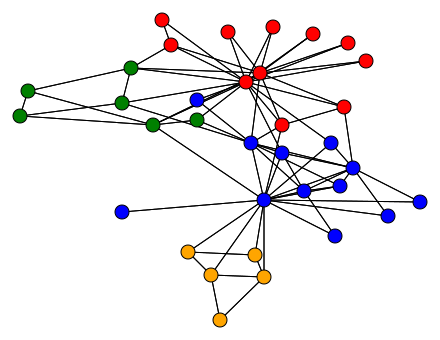

In [24]:
from IPython.display import SVG
from sknetwork.visualization import svg_graph

position = graph.position

image = svg_graph(
    adjacency=adj,
    position=position,
    labels=labels)

SVG(image)

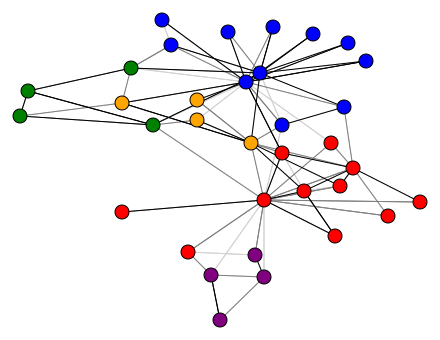

In [25]:
adj_w_coo = adj_w.tocoo()
edge_list_w = list(zip(adj_w_coo.row, adj_w_coo.col, adj_w_coo.data))

image = svg_graph(
    adjacency=adj,
    position=position,
    labels=labels_w,
    edge_labels = [(u, v, int(3*w)+5) for (u, v, w) in edge_list_w],
    label_colors={0: 'red', 1: 'blue', 2: 'orange', 3: 'purple', 4: 'green',
                  5: 'lightgrey', 6: 'grey', 7:'black'})

SVG(image)